## Load Modules/Data and Show Initial Tables

In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style='ticks', color_codes=True) 

from os.path import isfile

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import  GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.impute import KNNImputer


# Load the datasets
root_path = './datasets/titanic/'

train_path = root_path + 'train.csv'
test_path = root_path + 'test.csv'
target_path = root_path + 'gender_submission.csv'

paths = [train_path, test_path, target_path]

for path in paths:
    if not isfile(path):
        print(f"Dataset {path} not found. Please check that the dataset exists and the path is correct.")
        
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
test_tar = pd.read_csv(target_path)
    
def show_tables(n=10):
    display(train.head(n))
    display(test.head(n))
    display(test_tar.head(n))
    
# Show the tables
show_tables()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
5,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S
6,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q
7,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C
9,901,3,"Davies, Mr. John Samuel",male,21.0,2,0,A/4 48871,24.1500,NaN,S


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


## Cleanup Data

### Drop non-essential and sparse data features

I had some duplicate checking here earlier, but I removed it because there don't appear to be duplicates in the data. That could be from clerical errors, but my results are pretty good.

In [2]:
# Name and ID are just useless identifiers.
# Ticket and Cabin might be useful if there was a correlation with cabin position and 
# survivability but they're pretty sparse.
# Embarked is superfluous as all three classes of passenger may embark from any port.

useless = ['Name', 'PassengerId', 'Ticket', 'Cabin', 'Embarked']

train.drop(columns=useless, inplace=True)
test.drop(columns=useless, inplace=True)

# Show the adjusted tables
show_tables()

# Show types
display(train.dtypes)
display(test.dtypes)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,male,22.0,1,0,7.2500
1,1,1,female,38.0,1,0,71.2833
2,1,3,female,26.0,0,0,7.9250
3,1,1,female,35.0,1,0,53.1000
4,0,3,male,35.0,0,0,8.0500
5,0,3,male,NaN,0,0,8.4583
6,0,1,male,54.0,0,0,51.8625
7,0,3,male,2.0,3,1,21.0750
8,1,3,female,27.0,0,2,11.1333
9,1,2,female,14.0,1,0,30.0708


,Pclass,Sex,Age,SibSp,Parch,Fare
0,3,male,34.5,0,0,7.8292
1,3,female,47.0,1,0,7.0000
2,2,male,62.0,0,0,9.6875
3,3,male,27.0,0,0,8.6625
4,3,female,22.0,1,1,12.2875
5,3,male,14.0,0,0,9.2250
6,3,female,30.0,0,0,7.6292
7,2,male,26.0,1,1,29.0000
8,3,female,18.0,0,0,7.2292
9,3,male,21.0,2,0,24.1500


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
dtype: object

Pclass      int64
Sex        object
Age       float64
SibSp       int64
Parch       int64
Fare      float64
dtype: object

In [3]:
# Check for nulls
display("Train Nulls?", train.isnull().any())
display("Test Nulls?", test.isnull().any())
display("Target Nulls?", test_tar.isnull().any())

'Train Nulls?'

Survived    False
Pclass      False
Sex         False
Age          True
SibSp       False
Parch       False
Fare        False
dtype: bool

'Test Nulls?'

Pclass    False
Sex       False
Age        True
SibSp     False
Parch     False
Fare       True
dtype: bool

'Target Nulls?'

PassengerId    False
Survived       False
dtype: bool

In [4]:
# Found nulls in train['Age'], test['Age'], and test['Fare']
display("Train Nulls")
display(train[train['Age'].isnull()].head())

display("Test Nulls")
display(test[test['Age'].isnull()].head())
display(test[test['Fare'].isnull()].head())

'Train Nulls'

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
5,0,3,male,NaN,0,0,8.4583
17,1,2,male,NaN,0,0,13.0000
19,1,3,female,NaN,0,0,7.2250
26,0,3,male,NaN,0,0,7.2250
28,1,3,female,NaN,0,0,7.8792


'Test Nulls'

,Pclass,Sex,Age,SibSp,Parch,Fare
10,3,male,NaN,0,0,7.8958
22,1,female,NaN,0,0,31.6833
29,3,male,NaN,2,0,21.6792
33,3,female,NaN,1,2,23.4500
36,3,female,NaN,0,0,8.0500


,Pclass,Sex,Age,SibSp,Parch,Fare
152,3,male,60.5,0,0,NaN


### Discretize data

Only thing that needs to be discretized after dropping columns is 'Sex'

In [5]:
discretize = ['Sex']

# Taken from module 3 notebook
def encode_onehot(_df, f):
    _df2 = pd.get_dummies(_df[f], prefix='', prefix_sep='').max(level=0, axis=1).add_prefix(f+' - ')
    df3 = pd.concat([_df, _df2], axis=1)
    df3 = df3.drop([f], axis=1)
    return df3

for dis in discretize:
    train = encode_onehot(train, dis)
    test = encode_onehot(test, dis)

### Impute missing values with k-Nearest Neighbors Imputer

In [6]:
# Impute nulls with KNN imputation
imputer = KNNImputer()

train_knn = imputer.fit_transform(train)
test_knn = imputer.fit_transform(test)

train_knn = pd.DataFrame(train_knn)
test_knn = pd.DataFrame(test_knn)

train_knn.columns = train.columns
test_knn.columns = test.columns

# check our work
display(train_knn.isnull().any())
display(test_knn.isnull().any())

# Show the current state of the table
show_tables()

Survived        False
Pclass          False
Age             False
SibSp           False
Parch           False
Fare            False
Sex - female    False
Sex - male      False
dtype: bool

Pclass          False
Age             False
SibSp           False
Parch           False
Fare            False
Sex - female    False
Sex - male      False
dtype: bool

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex - female,Sex - male
0,0,3,22.0,1,0,7.2500,0,1
1,1,1,38.0,1,0,71.2833,1,0
2,1,3,26.0,0,0,7.9250,1,0
3,1,1,35.0,1,0,53.1000,1,0
4,0,3,35.0,0,0,8.0500,0,1
5,0,3,NaN,0,0,8.4583,0,1
6,0,1,54.0,0,0,51.8625,0,1
7,0,3,2.0,3,1,21.0750,0,1
8,1,3,27.0,0,2,11.1333,1,0
9,1,2,14.0,1,0,30.0708,1,0


,Pclass,Age,SibSp,Parch,Fare,Sex - female,Sex - male
0,3,34.5,0,0,7.8292,0,1
1,3,47.0,1,0,7.0000,1,0
2,2,62.0,0,0,9.6875,0,1
3,3,27.0,0,0,8.6625,0,1
4,3,22.0,1,1,12.2875,1,0
5,3,14.0,0,0,9.2250,0,1
6,3,30.0,0,0,7.6292,1,0
7,2,26.0,1,1,29.0000,0,1
8,3,18.0,0,0,7.2292,1,0
9,3,21.0,2,0,24.1500,0,1


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0


## Construct and Run Pipeline

In [7]:
# Prepare training set
x_train = train_knn.loc[:, train_knn.columns != 'Survived'].values
y_train = train_knn.loc[:, train_knn.columns == 'Survived'].values.ravel()

# Prepare test set
y_test = test_tar.loc[:, test_tar.columns == 'Survived'].values.ravel()

# Model Declaration
model = GaussianNB()

# Construct Pipeline and Train/Test
pipe_lr = make_pipeline(StandardScaler(), model)
pipe_lr.fit(x_train, y_train)
y_pred = pipe_lr.predict(test_knn)

print(confusion_matrix(y_test, y_pred).ravel())
print(accuracy_score(y_test, y_pred))

[252  14   4 148]
0.9569377990430622


## 96% Accuracy

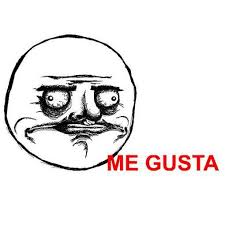

## Export for Kaggle

In [9]:
def save_preds(_fn, _y_pred, _df):
    import csv
    with open(_fn, 'w') as fout:
        writer = csv.writer(fout, delimiter=',', lineterminator='\n')
        writer.writerow(['Survived', 'PassengerId'])
        for y, passengerId in zip(_y_pred, _df['PassengerId']):
            writer.writerow([y, passengerId])

save_preds('predictions_mcelhenney.csv', y_pred, df_test_org)

NameError: name 'df_test_org' is not defined